<a href="https://colab.research.google.com/github/JanMikicki/various-rl-things/blob/main/alpha_tictac_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from decimal import Decimal
from copy import deepcopy
from math import sqrt, log

In [ ]:
class OXOState:
    """ State of the game which carries board and turn information
    throughout the episode.
    """
    def __init__(self, net):
        """ Decide who goes first at the beginning of a game
            (doesn't really matter) and init the board
        """
        self.playerJustMoved = np.random.choice([1, 2])
        self.board = np.zeros((3, 3), dtype=np.uint8)
        self.net = net
        
    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
    
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        free_fields = np.where(self.board < 1)
        free_fields = list(zip(*free_fields))
        #import IPython; IPython.embed(); exit()
        return free_fields
    
    def GetValue(self, lastplayer):
        """ Get value (from 1's perspective) of the board given that lastplayer moved. 
        """
        netboard = construct_netboard(self.board, lastplayer)
        netboard = torch.from_numpy(netboard).to(self.net.device)
        V, _ = self.net.forward(netboard)
        return V
        
    def GetPolicy(self):
        """ Get the policy distribution for current board and playerjm. 
        """
        netboard = construct_netboard(self.board, self.playerJustMoved)
        netboard = torch.from_numpy(netboard).to(self.net.device)
        _, P = self.net.forward(netboard)
        P = F.softmax(P.squeeze(0), dim=0)
        return P

    def GetResult(self):
        """ Get the game result. Return vals:
            1.0 - someone won
            0.0 - draw
            10  - still ongoing 
        """
        for rowcol in range(3):
            if (self.board[rowcol] == 1).all() \
            or (self.board[:, rowcol] == 1).all():               
                return 1.0

            if (self.board[rowcol] == 2).all() \
            or (self.board[:, rowcol] == 2).all():               
                return 1.0

        if self.board[0, 0] == self.board[1, 1] == self.board[2, 2]:
            if self.board[1, 1] != 0:
                return 1.0
        
        if self.board[0, 2] == self.board[1, 1] == self.board[2, 0]:
            if self.board[1, 1] != 0:
                return 1.0

        if len(self.GetMoves()) == 0:
            return 0.0 # draw

        return 10

In [ ]:
class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.Q = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.policy = state.GetPolicy()
        self.playerJustMoved = state.playerJustMoved
        
    def PUCTSelectChild(self):
        """ Use the PUCT formula to select a child node.
            In short, during a tree search we pick actions according to:
            a = argmax(Q + U)
            ,where U ~ (P / 1 + N) and Q = wins/visits
            c_puct was chosen based on some paper where they tested different values empirically
            the smaller the tau the less exploration
        """
        # s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        moves = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
        c_puct = 3 # was 3-4 in paper
        tau = 0.1

        # Decimal conversion is here because it was getting overflows with high visits and small tau
        s = sorted(self.childNodes, key = lambda c: c.Q + \
            c_puct * self.policy[moves.index(c.move)] * \
                float( (Decimal(np.sqrt(Decimal(self.visits))) ** Decimal(1/tau)) / (Decimal(c.visits) ** Decimal(1/tau)) ))[-1]

        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result
        self.Q = self.wins / self.visits

In [ ]:
def MCTS(rootstate, itermax, verbose = False):
    """ Conduct a Monte Carlo Tree Search for itermax iterations starting from rootstate.
        Return the move policy (probability distribution) from the rootstate.
    """

    rootnode = Node(state = rootstate)
    #print("Starting MCTS...")
    for i in range(itermax):

        node = rootnode
        state = deepcopy(rootstate)

        is_endgame = True if state.GetResult() == 1.0 else False
        
        # Select
        if not is_endgame:
            while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
                node = node.PUCTSelectChild()
                state.DoMove(node.move)
                
        # Expand
        if is_endgame == False and node.untriedMoves != []: # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state) # add child and descend tree

        # Backpropagate
        leaf_value = state.GetValue(state.playerJustMoved)
        while node != None:
            # Update nodes with leaf result from POV of node.playerJustMoved
            if node.playerJustMoved == 2:
                node.Update(-leaf_value)
            else:
                node.Update(leaf_value)
            node = node.parentNode

    # Return the policy based on number of visits
    moves = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
    policy = []
    for m in moves:
        found = False
        for child in rootnode.childNodes:
            if m == child.move:
                policy.append(child.visits/rootnode.visits)
                found = True
                break
        if not found: policy.append(0.0)    # move not possible

    return policy


In [ ]:
def construct_netboard(board, playerjm):
    """ Make a board representation like they used in AlphaZero """

    netboard = np.zeros((3, 3, 3), dtype=np.int8)
    netboard[2][:] = 1 if playerjm == 1 else 0
    netboard[0][board==1] = 1
    netboard[1][board==2] = 1

    return netboard

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        # These data types are what they are because PyTorch likes it like that
        self.board_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.mindx_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.result_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, board_state, move_taken, who_won):
        index = self.mem_cntr % self.mem_size
        
        self.board_memory[index] = board_state
        self.mindx_memory[index] = move_taken
        self.result_memory[index] = who_won
        self.mem_cntr += 1
    
    def sample_buffer(self, batch_size):
        # Don't sample emptiness before filling
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False)
        boards = self.board_memory[batch]
        move_idxs = self.mindx_memory[batch]
        results = self.result_memory[batch]

        return (boards, move_idxs, results)

In [ ]:
class Network(nn.Module):
    def __init__(self, lr=0.01, n_actions=9, input_dims=[3, 3, 3]):
        super().__init__()

        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Flatten()
        )

        self.resblock = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.Flatten()
        )
        # Alphazero has a bunch more layers but
        # it seems ridiculous for a 3x3 board...

        # self.V = nn.Linear(128 * 2 * 2, 1)
        # self.P = nn.Linear(128 * 2 * 2, 9)

        self.V = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 1)
        )

        self.P = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 9)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        print("Nr of available devices: ", torch.cuda.device_count())
        print("Name of the zero device: ", torch.cuda.get_device_name(0))
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Assifned device: ", self.device)
        #self.nll_loss = nn.NLLLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()
        self.to(self.device)

    def forward(self, x):

        if len(list(x.size())) == 3:
            x = x.unsqueeze(0)

        x = x.float()
        x = self.convblock(x)
        for _ in range(5):
            x = self.resblock(x)
        
        value = self.V(x)
        policy = self.P(x)

        return value, policy

    def learn(self, batch):
        
        netboards, move_idxs, results = batch
        netboards = torch.from_numpy(netboards).to(self.device)

        

        results = torch.from_numpy(results).to(self.device).unsqueeze(1)
        
        move_idxs = torch.from_numpy(move_idxs).to(self.device)
        move_idxs.long()
        
        # This could/should not be done in a loop, really
        self.optimizer.zero_grad()
        loss = 0

        #import IPython; IPython.embed(); exit()

        predicted_vs, predicted_ps = self.forward(netboards)
        v_loss = self.mse_loss(predicted_vs, results)
        p_loss = self.ce_loss(predicted_ps, move_idxs )

        loss = v_loss + p_loss
        # for i in range(len(results)):
        #     predicted_v, predicted_p = self.forward(netboards[i])
        #     #v_loss = (results[i] - predicted_v) ** 2
        #     v_loss = self.mse_loss(predicted_v, results[i].unsqueeze(0))
        #     p_loss = self.ce_loss(predicted_p.unsqueeze(0), move_idxs[i].unsqueeze(0) )
        #     #p_loss = self.nll_loss(torch.log(predicted_p.unsqueeze(0)), move_idxs[i].unsqueeze(0))
        #     # input = tensor([[0.2, 0.1, 0.6...]]) (size (1, 9))
        #     # target = tensor([4])  index (size (1,)) dtype long

        #     loss += v_loss + p_loss
        
        loss.backward()
        self.optimizer.step()

    def save_checkpoint(self):
        print("... saving checkpoint ...")
        torch.save(self.state_dict(), "checkpt_" + time.strftime("%Y%m%d-%H%M"))

    def load_checkpoint(self, file):
        print("... loading checkpoint ...")
        self.load_state_dict(torch.load(file)) 

In [ ]:
def play_game_against_random(wins_against_random, moves_against_random, net):
    # Play one episode against an opponent who's making random moves
    
    net.eval()
    quick_state = OXOState(net=net)
    player = np.random.choice([1, 2])
    win = False
    move_cnt = 0

    while (len(quick_state.GetMoves()) != 0):   
        
        if player == 1:
            policy = MCTS(rootstate = quick_state, itermax = 200, verbose = False)
            #m_idx = np.random.choice(9, p=policy)
            m_idx = np.argmax(policy)
            moves = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
            m = moves[m_idx]
        else:
            m = random.choice(quick_state.GetMoves())
        
        quick_state.DoMove(m)
        move_cnt += 1
        
        if quick_state.GetResult() == 1.0:
            win = True
            res = 1 if player == 1 else -1
            if res == 1:
                moves_against_random.append(move_cnt)
            wins_against_random.append(res)
            break
        
        player = 3 - player

    if not win:
        wins_against_random.append(0)

In [ ]:
def PlayGames(n_eps=5000, batch_size=32, load_checkpoint=False, checkpoint_path=''):
    """ Play n_eps games between two equal AI players, and
        update parameters after each episode.
    """
    replay_buffer = ReplayBuffer(max_size=10000, input_shape=(3, 3, 3))

    net = Network()         # learns constantly
    target_net = Network()  # generates episodes, copies net every 1k

    if load_checkpoint:
        net.load_checkpoint(checkpoint_path)

    wins_random = []
    moves_random = []

    for episode in range(n_eps):
        
        net.eval()

        if not (episode + 1) % 100:
            print(f"Episode {episode}")
            print("Playing random....")
            play_game_against_random(wins_random, moves_random, net)

        if not episode % 500:
            plt.plot(wins_random)
            plt.plot(moves_random)
            plt.show()

        if not (episode + 1) % 1500:
            net.save_checkpoint()

        state = OXOState(net=target_net)
        netboard = construct_netboard(state.board, state.playerJustMoved)

        netboard_memory = [netboard]
        midx_memory = []

        while(state.GetResult() == 10):
            
            policy = MCTS(rootstate = state, itermax = 50, verbose = False)

            m_idx = np.random.choice(9, p=policy)
            midx_memory.append(m_idx)
            moves = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
            m = moves[m_idx]
            state.DoMove(m)

            netboard = construct_netboard(state.board, state.playerJustMoved)
            netboard_memory.append(netboard)

        #who_won = 0 if state.GetResult() == 0.0 else state.playerJustMoved
        if state.GetResult() == 0.0:        who_won = 0
        elif state.playerJustMoved == 2:    who_won = -1
        else:                               who_won = 1

        # I have to retroactively store episode
        # in buffer here because only now do I know who won
        for i in range(len(netboard_memory)):
            if i == len(netboard_memory) - 1:
                midx = 0        # what's a good solution?
            else: 
                midx = midx_memory[i]

            netboard = netboard_memory[i]
            replay_buffer.store_transition(netboard, midx, who_won)


        if replay_buffer.mem_cntr > batch_size:
            batch = replay_buffer.sample_buffer(batch_size)
            net.train()
            net.learn(batch)

        if not episode % 1000:
            print("Updating target net and wiping memory...")
            target_net.load_state_dict(net.state_dict())
            replay_buffer = ReplayBuffer(max_size=10000, input_shape=(3, 3, 3))

    net.save_checkpoint()

In [ ]:
def PlayGameWithHuman(checkpoint_path):

    #replay_buffer = ReplayBuffer(max_size=1000, input_shape=(3, 3, 3))
    net = Network()
    net.load_checkpoint(checkpoint_path)
    state = OXOState(net=net)
    
    while (state.GetResult() == 10):

        policy = MCTS(rootstate = state, itermax = 600, verbose = False)
        print("policy: ", policy)
        #m_idx = np.random.choice(9, p=policy)
        m_idx = np.argmax(policy)
        moves = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
        m = moves[m_idx]
        print("Chosen Move: ", m, "\n")
        state.DoMove(m)

        print("Real board:")
        print(state.board)

        if state.GetResult() == 1.0:
            print(state.playerJustMoved, "won!")
            break
        elif state.GetResult() == 0.0:
            print("draw")
            break

        print("Pick a move")
        human_m = tuple(int(x.strip()) for x in input().split(','))
        state.DoMove(human_m)

        if state.GetResult() == 1.0:
            print(state.playerJustMoved, "won!")
            break
        elif state.GetResult() == 0.0:
            print("draw")
            break

Nr of available devices:  1
Name of the zero device:  Tesla T4
Assifned device:  cuda
Nr of available devices:  1
Name of the zero device:  Tesla T4
Assifned device:  cuda


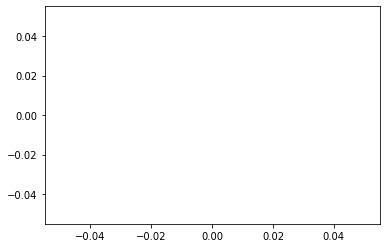

Updating target net and wiping memory...
Episode 99
Playing random....
Episode 199
Playing random....
Episode 299
Playing random....
Episode 399
Playing random....
Episode 499
Playing random....


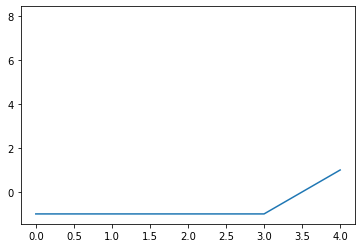

Episode 599
Playing random....
Episode 699
Playing random....
Episode 799
Playing random....
Episode 899
Playing random....
Episode 999
Playing random....


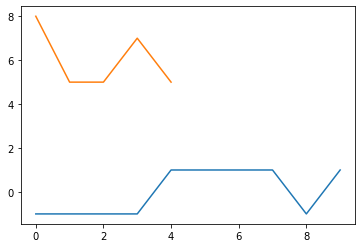

Updating target net and wiping memory...
Episode 1099
Playing random....
Episode 1199
Playing random....
Episode 1299
Playing random....
Episode 1399
Playing random....
Episode 1499
Playing random....
... saving checkpoint ...


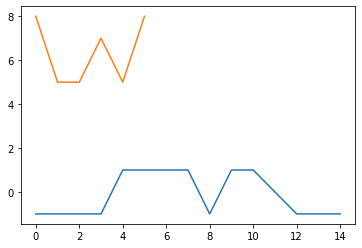

Episode 1599
Playing random....
Episode 1699
Playing random....
Episode 1799
Playing random....
Episode 1899
Playing random....
Episode 1999
Playing random....


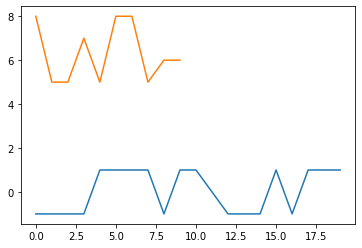

Updating target net and wiping memory...
Episode 2099
Playing random....
Episode 2199
Playing random....
Episode 2299
Playing random....
Episode 2399
Playing random....
Episode 2499
Playing random....


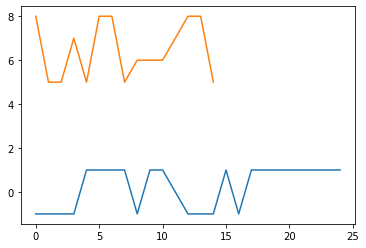

Episode 2599
Playing random....
Episode 2699
Playing random....
Episode 2799
Playing random....
Episode 2899
Playing random....
Episode 2999
Playing random....
... saving checkpoint ...


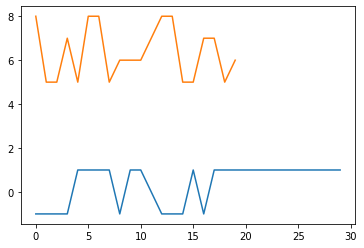

Updating target net and wiping memory...
Episode 3099
Playing random....
Episode 3199
Playing random....
Episode 3299
Playing random....
Episode 3399
Playing random....
Episode 3499
Playing random....


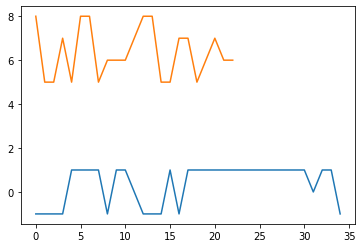

Episode 3599
Playing random....
Episode 3699
Playing random....
Episode 3799
Playing random....
Episode 3899
Playing random....
Episode 3999
Playing random....


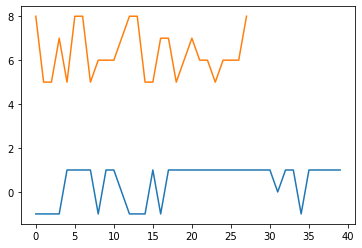

Updating target net and wiping memory...
Episode 4099
Playing random....
Episode 4199
Playing random....
Episode 4299
Playing random....
Episode 4399
Playing random....
Episode 4499
Playing random....
... saving checkpoint ...


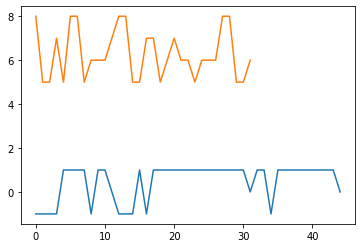

Episode 4599
Playing random....
Episode 4699
Playing random....


In [ ]:
%matplotlib inline

n_eps = 10000

PlayGames(n_eps, batch_size=32)
#PlayGameWithHuman()